# qTPU Basics

In this brief tutorial we go through the process of 
1. compiling a large quantum circuit into an efficient `hybrid tensor network`, consisting of classical- and smaller quantum-tensors, and
2. contracting a hybrid tensor network using both classical and quantum devices to obtain the result of the circuit.

In [1]:
import numpy as np
from qiskit.circuit.library import TwoLocal
from IPython.display import display
import qtpu

We start by creating a random ansatz with linear entanglement:

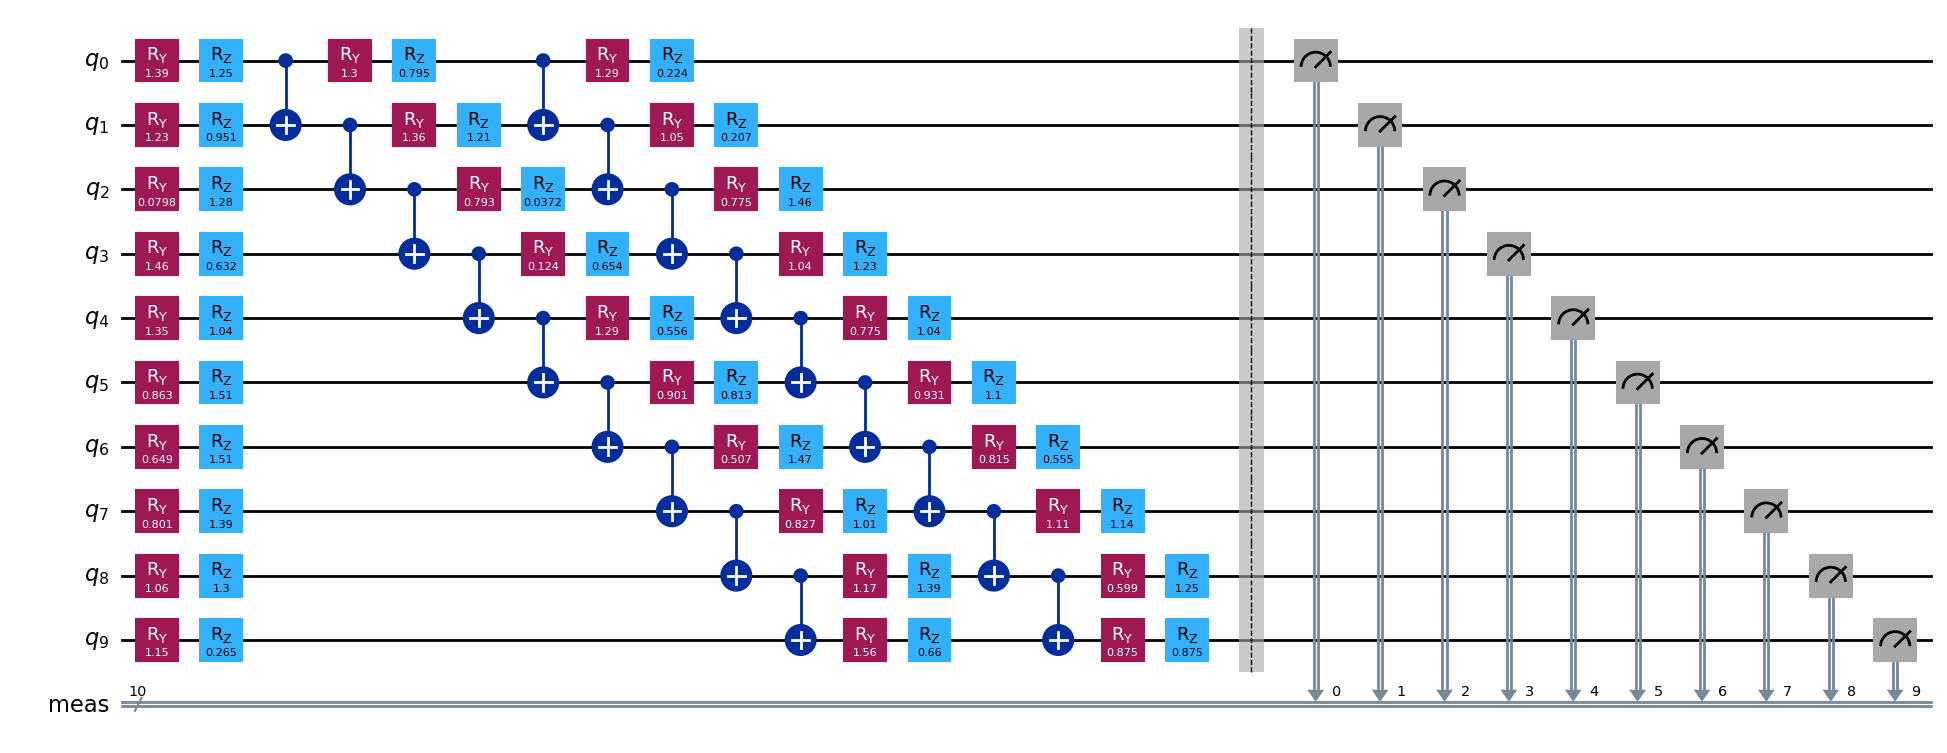

In [2]:
N = 10
circuit = TwoLocal(N, ["ry", "rz"], "cx", entanglement="linear", reps=2).decompose()
circuit = circuit.assign_parameters(
    {param: np.random.rand() * np.pi / 2 for param in circuit.parameters}
)
circuit.measure_all()

circuit.draw("mpl", fold=-1)

## Compiling (cutting) the circuit

To compile the circuit into an efficient hybrid tensor network, we can use the `qtpu.cut` function. This function uses hyperparameter-optimization to find a good partitioning of the circuit, and then creates a hybrid TN of the partitioned circuit.
In this case, we use the terminator `reach_num_qubits(N//2)` to specify that we want the quantum-tensors to use at most `N/2` qubits.

In [3]:
from qtpu.compiler.terminators import reach_num_qubits

hybrid_tn = qtpu.cut(circuit, terminate_fn=reach_num_qubits(N//3+1), max_cost=2000, show_progress_bar=True, n_trials=100)

  0%|          | 0/100 [00:00<?, ?it/s]

È (0, 1)
Ê (1, 4)
É (2, 3)
Ë (3, 5)
Ì (4, 5)
Í (4, 6)
Ð (5, 10)
Î (6, 7)
Õ (7, 14)
Ï (8, 9)
Ñ (9, 11)
Ò (10, 11)
Ó (10, 12)
Û (11, 20)
Ô (12, 13)
Ö (13, 15)
× (14, 15)
Ø (14, 16)
à (15, 24)
Ù (16, 17)
İ (17, 96)
Ú (18, 19)
Ü (19, 21)
Ý (20, 21)
Þ (20, 22)
æ (21, 30)
ß (22, 23)
á (23, 25)
â (24, 25)
ã (24, 26)
ë (25, 34)
ä (26, 27)
ı (27, 97)
å (28, 29)
ç (29, 31)
è (30, 31)
é (30, 32)
ñ (31, 40)
ê (32, 33)
ì (33, 35)
í (34, 35)
î (34, 36)
ö (35, 44)
ï (36, 37)
Ĳ (37, 98)
ð (38, 39)
ò (39, 41)
ó (40, 41)
ô (40, 42)
ü (41, 50)
õ (42, 43)
÷ (43, 45)
ø (44, 45)
ù (44, 46)
ā (45, 54)
ú (46, 47)
ĳ (47, 99)
û (48, 49)
ý (49, 51)
þ (50, 51)
ÿ (50, 52)
ć (51, 60)
Ā (52, 53)
Ă (53, 55)
ă (54, 55)
Ą (54, 56)
Č (55, 64)
ą (56, 57)
Ĵ (57, 100)
Ć (58, 59)
Ĉ (59, 61)
ĉ (60, 61)
Ċ (60, 62)
Ē (61, 70)
ċ (62, 63)
č (63, 65)
Ď (64, 65)
ď (64, 66)
ė (65, 74)
Đ (66, 67)
ĵ (67, 101)
đ (68, 69)
ē (69, 71)
Ĕ (70, 71)
ĕ (70, 72)
ĝ (71, 80)
Ė (72, 73)
Ę (73, 75)
ę (74, 75)
Ě (74, 76)
Ģ (75, 84)
ě (76, 77)
Ķ (77

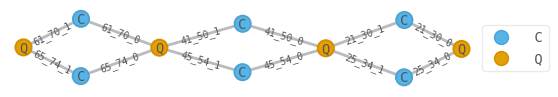

In [4]:
from qtpu.visualization import draw_hybrid_tn
draw_hybrid_tn(hybrid_tn);

We can now inspect the resulting hybrid TN.

The hybrid TN consists of two quantum tensors, which are defined as instatiable circuits, meaning that the circuit have placeholder gates that are filled in during execution.

shape: (4, 4), indices: ('21_30_0', '25_34_0')


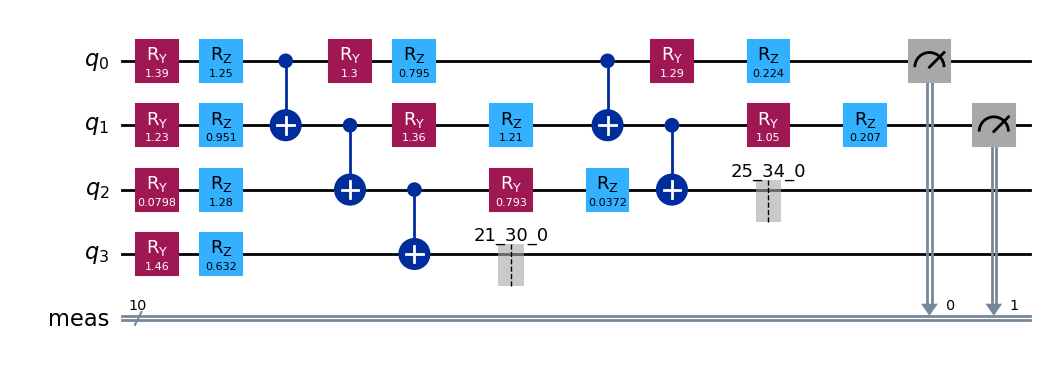

shape: (4, 4, 4, 4), indices: ('21_30_1', '25_34_1', '41_50_0', '45_54_0')


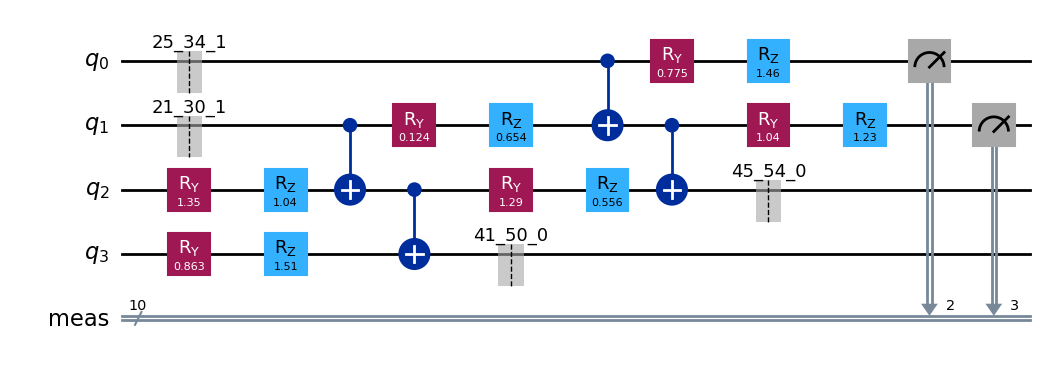

shape: (4, 4), indices: ('61_70_1', '65_74_1')


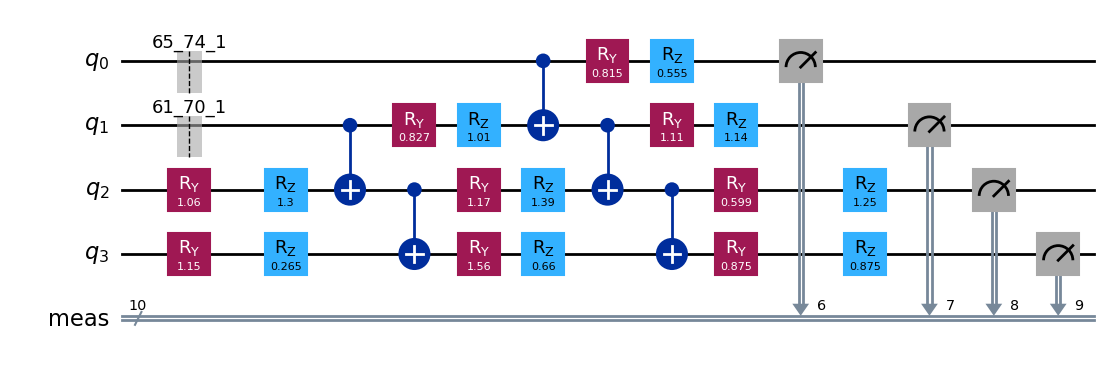

shape: (4, 4, 4, 4), indices: ('41_50_1', '45_54_1', '61_70_0', '65_74_0')


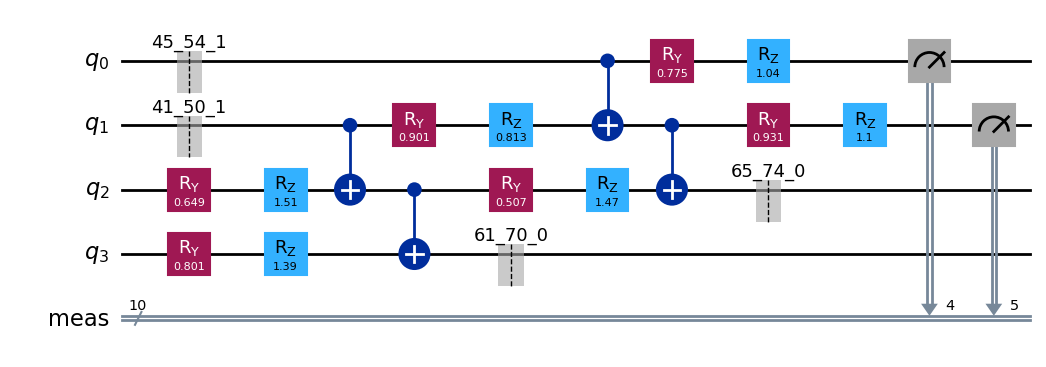

In [5]:
for qtensor in hybrid_tn.quantum_tensors:
    print(f"shape: {qtensor.shape}, indices: {qtensor.inds}")
    # for circuit, _ in qtensor.generate_instances():
    #     display(circuit.draw('mpl', fold=-1))
    display(qtensor.circuit.draw('mpl', fold=-1))

For the contraction (using quasiprobability decomposition), the hybrid TN also has two classical tensors, corresponding to the two 2-qubit gates that have been cut in th circuit.

In [6]:
for ctensor in hybrid_tn.classical_tensors:
    print(f"shape: {ctensor.shape}, indices: {ctensor.inds}")
    print(ctensor.data)

shape: (4, 4), indices: ('61_70_0', '61_70_1')
[[ 0.5  0.5  0.   0. ]
 [ 0.5 -0.5  0.   0. ]
 [-0.5 -0.5  1.   0. ]
 [-0.5 -0.5  0.   1. ]]
shape: (4, 4), indices: ('45_54_0', '45_54_1')
[[ 0.5  0.5  0.   0. ]
 [ 0.5 -0.5  0.   0. ]
 [-0.5 -0.5  1.   0. ]
 [-0.5 -0.5  0.   1. ]]
shape: (4, 4), indices: ('25_34_0', '25_34_1')
[[ 0.5  0.5  0.   0. ]
 [ 0.5 -0.5  0.   0. ]
 [-0.5 -0.5  1.   0. ]
 [-0.5 -0.5  0.   1. ]]
shape: (4, 4), indices: ('65_74_0', '65_74_1')
[[ 0.5  0.5  0.   0. ]
 [ 0.5 -0.5  0.   0. ]
 [-0.5 -0.5  1.   0. ]
 [-0.5 -0.5  0.   1. ]]
shape: (4, 4), indices: ('21_30_0', '21_30_1')
[[ 0.5  0.5  0.   0. ]
 [ 0.5 -0.5  0.   0. ]
 [-0.5 -0.5  1.   0. ]
 [-0.5 -0.5  0.   1. ]]
shape: (4, 4), indices: ('41_50_0', '41_50_1')
[[ 0.5  0.5  0.   0. ]
 [ 0.5 -0.5  0.   0. ]
 [-0.5 -0.5  1.   0. ]
 [-0.5 -0.5  0.   1. ]]


## Contracting the hybrid tensor network

Finally, we can contract the hybrid TN using `qtpu.contract`. To do so we need to specify the total number of shots that will be divided between the quantum tensors, as well as a `QuantumInterface` to run the quantum circuit instances.

In doing so, qTPU allows for two contraction modes:
1. Contracting the entire sampling probability distribution, and
2. Contracting an expectation value (currently only Z-expvals), which is more efficient and allows GPU-acceleration.

In [7]:
from qiskit_aer import AerSimulator
from qtpu.evaluate import evaluate_estimator


result_samples = qtpu.contract(hybrid_tn)
prob_dist = result_samples.nearest_probability_distribution()
sorted(prob_dist.items(), key=lambda x: x[1], reverse=True)[:10]

Running 544 circuits...
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[[[[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]]


 [[[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]]


 [[[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]]


 [[[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]


AttributeError: 'float' object has no attribute 'nearest_probability_distribution'

In [ ]:
result_exp = qtpu.contract(hybrid_tn)
result_exp

Running 1040 circuits...
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[[[[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]]

  [[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]]

  [[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]]

  [[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]]]


 [[[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]]

  [[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]]

  [[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]]

  [[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]]]


 [[[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]

1.0

Finally, compare to reference:

In [ ]:
from qiskit.primitives import Sampler, Estimator
from qiskit.quantum_info import hellinger_fidelity

ref_samples = Sampler().run(circuit, shots=1000000).result().quasi_dists[0]

ref_circ = circuit.copy()
ref_circ.remove_final_measurements()
ref_expval = Estimator().run(ref_circ, ["Z" * N]).result().values[0]

print("Fidelities:")
# print(hellinger_fidelity(ref_samples, prob_dist))
print(1 - abs(ref_expval - result_exp))

Fidelities:
-0.023823087887083982
